In [1]:
%load_ext autoreload
%autoreload 2

# Density at 150 pc - pericenter relation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py

from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import run_best_fit, log_model
from density_pericenter_fit_utils import run_best_fit_for_sim
from density_pericenter_fit_utils import run_best_fit_for_sim_with_mcmc
from satellite_properties_plot_utils import plot_median_relation


plt.style.use("pltstyle.mplstyle")
params = {
    "font.size": 10,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (5, 2.5),
    "figure.subplot.left": 0.1,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)

## Gaia data with NFW fit

In [3]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

Vmax = Kaplinghat_data[:,2]
le_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,3]
he_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,4]
NFW_Vmax = 10**Vmax[::2] # Only NFW fit data; [km/s] units
le_NFW_Vmax = NFW_Vmax - 10**le_Vmax[::2] # Only NFW fit data; [km/s] units
he_NFW_Vmax = 10**he_Vmax[::2] - NFW_Vmax # Only NFW fit data; [km/s] units

Rmax = Kaplinghat_data[:,5]
le_Rmax = Kaplinghat_data[:,6] + Kaplinghat_data[:,5]
he_Rmax = Kaplinghat_data[:,7] + Kaplinghat_data[:,5]
NFW_Rmax = 10**Rmax[::2] # Only NFW fit data; [kpc] units
le_NFW_Rmax = NFW_Rmax - 10**le_Rmax[::2]  # Only NFW fit data; [kpc] units
he_NFW_Rmax = 10**he_Rmax[::2] - NFW_Rmax  # Only NFW fit data; [kpc] units
he_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2
le_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2

num_satellites = len(NFW_Rmax)
M200_K19 = np.zeros((3,num_satellites))
R200_K19 = np.zeros((3,num_satellites))

rho_s = np.zeros(num_satellites)
r_s = np.zeros(num_satellites)
r_range = np.arange(-4, 4, 0.01) # Some radial range
r_range = 10**r_range # to kpc

for i in range(num_satellites):
    rho_s[i] = calculate_rho_s(NFW_Vmax[i], NFW_Rmax[i])
    r_s[i] = calculate_r_s(NFW_Rmax[i])
    rho = NFW_profile(r_range, rho_s[i], r_s[i])
    mass_within_r = mass(rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[0, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[0, i] = calculate_M200(R200_K19[0, i])

    ## Dealing with error propagration..
    low_error_rho = rho - calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], le_NFW_Vmax[i], le_NFW_Rmax[i])
    mass_within_r = mass(low_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[1, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[1, i] = M200_K19[0, i] - calculate_M200(R200_K19[1, i])

    high_error_rho = rho + calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], he_NFW_Vmax[i], he_NFW_Rmax[i])
    mass_within_r = mass(high_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[2, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[2, i] = calculate_M200(R200_K19[2, i]) - M200_K19[0, i]

In [4]:
# We remove CVnI
num_satellites -= 1
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

Fit

In [5]:
samples_isolated = run_best_fit(r_p_Isolated, rho_150pc_K19)
samples_LMC = run_best_fit(r_p_LMC, rho_150pc_K19)

def get_q_m_from_samples(samples):
    q = np.median(samples[:, 0])
    m = np.median(samples[:, 1])
    qerrl = np.percentile(samples[:, 0], 16)
    qerrh = np.percentile(samples[:, 0], 84)
    merrl = np.percentile(samples[:, 1], 16)
    merrh = np.percentile(samples[:, 1], 84)
    return q, m, qerrl, qerrh, merrl, merrh

q_isolated, m_isolated, qerrl_isolated, qerrh_isolated, merrl_isolated, merrh_isolated = get_q_m_from_samples(samples_isolated)
q_LMC, m_LMC, qerrl_LMC, qerrh_LMC, merrl_LMC, merrh_LMC = get_q_m_from_samples(samples_LMC)

2.6718527418666467 -0.8753657456390267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.91it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.28306742 26.20017204]


Multiprocessing took 0.0 minutes
Mean autocorrelation time: 26.242 steps
2.056094894457572 -0.4870925308372526


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 387.18it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.5744161  26.59308067]


Multiprocessing took 0.0 minutes
Mean autocorrelation time: 26.584 steps


Plot

(50000000.0, 10000000000.0, 10000000.0, 1000000000.0)

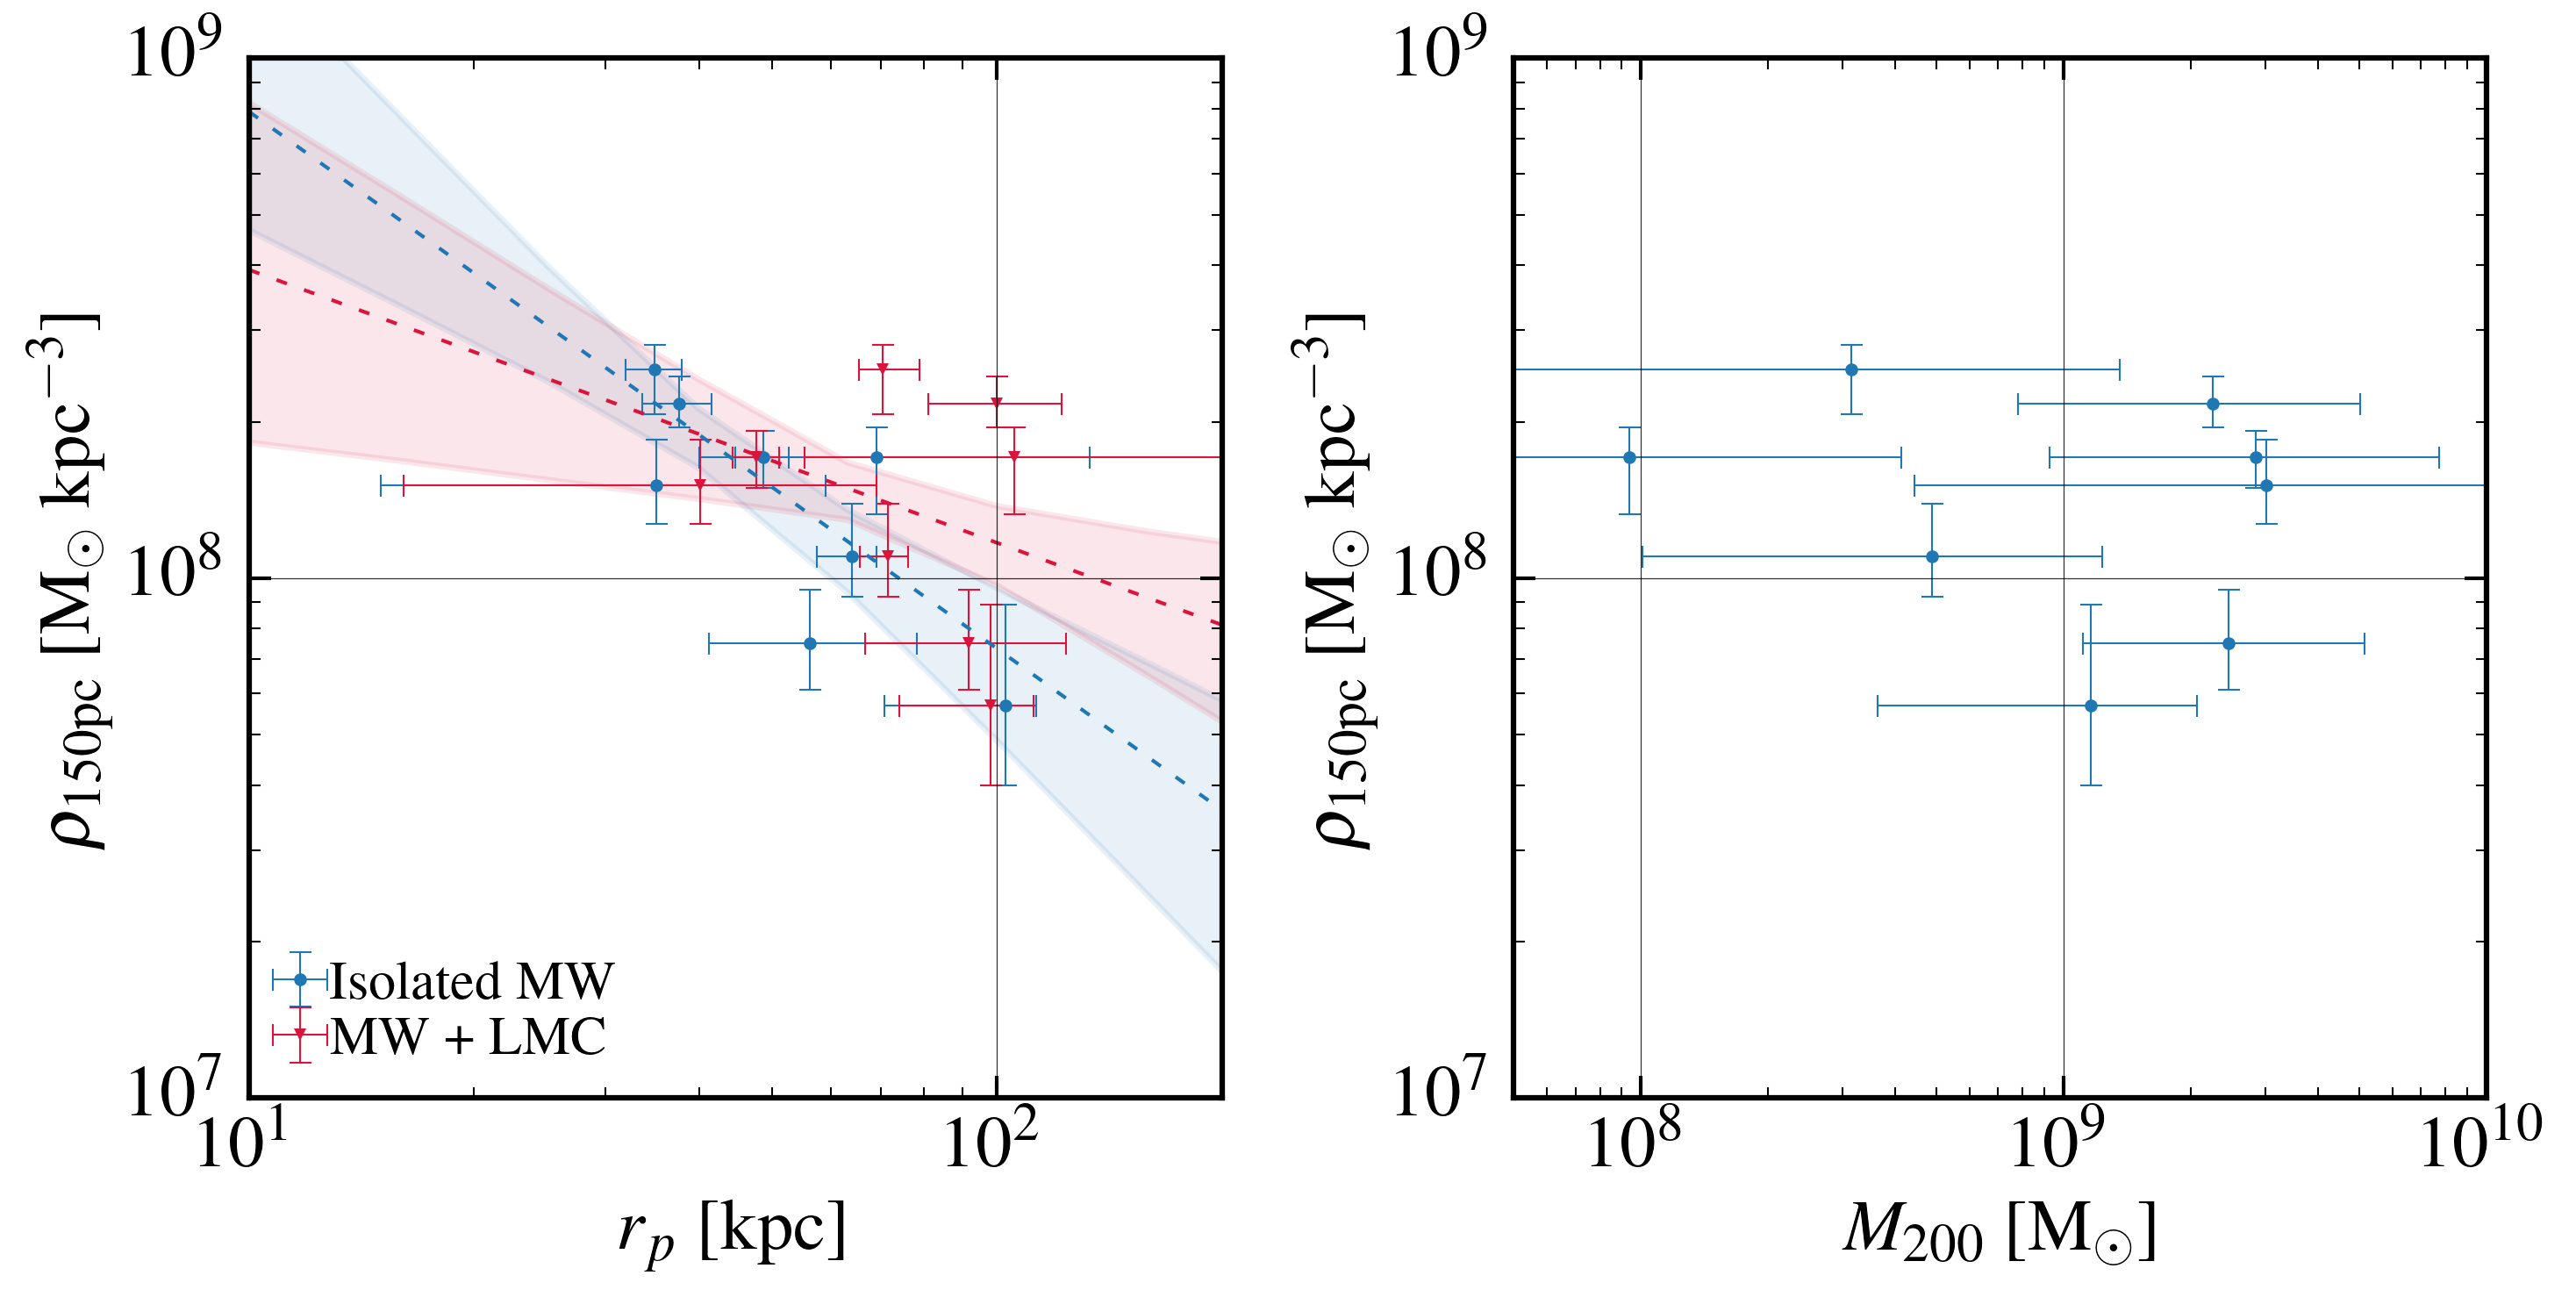

In [6]:
def plot_Gaia_data(axs):
    # Data points
    axs[0].errorbar(r_p_Isolated[0,:], rho_150pc_K19[0,:], xerr=r_p_Isolated[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='o', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='tab:blue',label='Isolated MW')
    axs[0].errorbar(r_p_LMC[0,:], rho_150pc_K19[0,:], xerr=r_p_LMC[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='v', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='crimson',label='MW + LMC')

    # Fit
    xrange = np.arange(np.log10(10), np.log10(500), 0.2)
    num_range = len(xrange)
    for samples, color in zip([samples_isolated, samples_LMC], ["tab:blue", "crimson"]):
        q = np.median(samples[:, 0])
        m = np.median(samples[:, 1])
        yrange = np.ones((2,num_range))
        for i in range(num_range):
            yrange[0, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 16)
            yrange[1, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 84)
        axs[0].fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color=color, alpha=0.1)
        axs[0].plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '--', lw=1, color=color)


    axs[0].grid(linestyle='-', linewidth=0.3)
    axs[0].legend(loc=[0.01, 0.01], labelspacing=0.1,
            handlelength=0.7, handletextpad=0.2,
            frameon=False, fontsize=15, ncol=1, numpoints=1)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    axs[0].set_xlabel("$r_{p}$ [kpc]")

    ####
    axs[1].grid(linestyle='-', linewidth=0.3)
    axs[1].errorbar(M200_K19[0,:-1], rho_150pc_K19[0,:], yerr=rho_150pc_K19[1:,:], xerr=M200_K19[1:,:-1],
                marker='o', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='tab:blue')

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    axs[1].set_xlabel("$M_{200}$ [M$_{\odot}$]")
    
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
plot_Gaia_data(axs)
axs[0].axis([10, 200, 1e7, 1e9])
axs[1].axis([5e7, 1e10, 1e7, 1e9])


## Here I redo the above plot but the fit assumes no information from the error distribution

In [7]:
samples_isolated = run_best_fit_for_sim_with_mcmc(r_p_Isolated[0,:], rho_150pc_K19[0,:])
samples_LMC = run_best_fit_for_sim_with_mcmc(r_p_LMC[0,:], rho_150pc_K19[0,:])

def get_q_m_from_samples(samples):
    q = np.median(samples[:, 0])
    m = np.median(samples[:, 1])
    qerrl = np.percentile(samples[:, 0], 16)
    qerrh = np.percentile(samples[:, 0], 84)
    merrl = np.percentile(samples[:, 1], 16)
    merrh = np.percentile(samples[:, 1], 84)
    return q, m, qerrl, qerrh, merrl, merrh

q_isolated, m_isolated, qerrl_isolated, qerrh_isolated, merrl_isolated, merrh_isolated = get_q_m_from_samples(samples_isolated)
q_LMC, m_LMC, qerrl_LMC, qerrh_LMC, merrl_LMC, merrh_LMC = get_q_m_from_samples(samples_LMC)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 542.76it/s]

Multiprocessing took 0.0 minutes
Mean autocorrelation time: 19.194 steps



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 540.53it/s]

Multiprocessing took 0.0 minutes
Mean autocorrelation time: 17.738 steps


(50000000.0, 10000000000.0, 10000000.0, 1000000000.0)

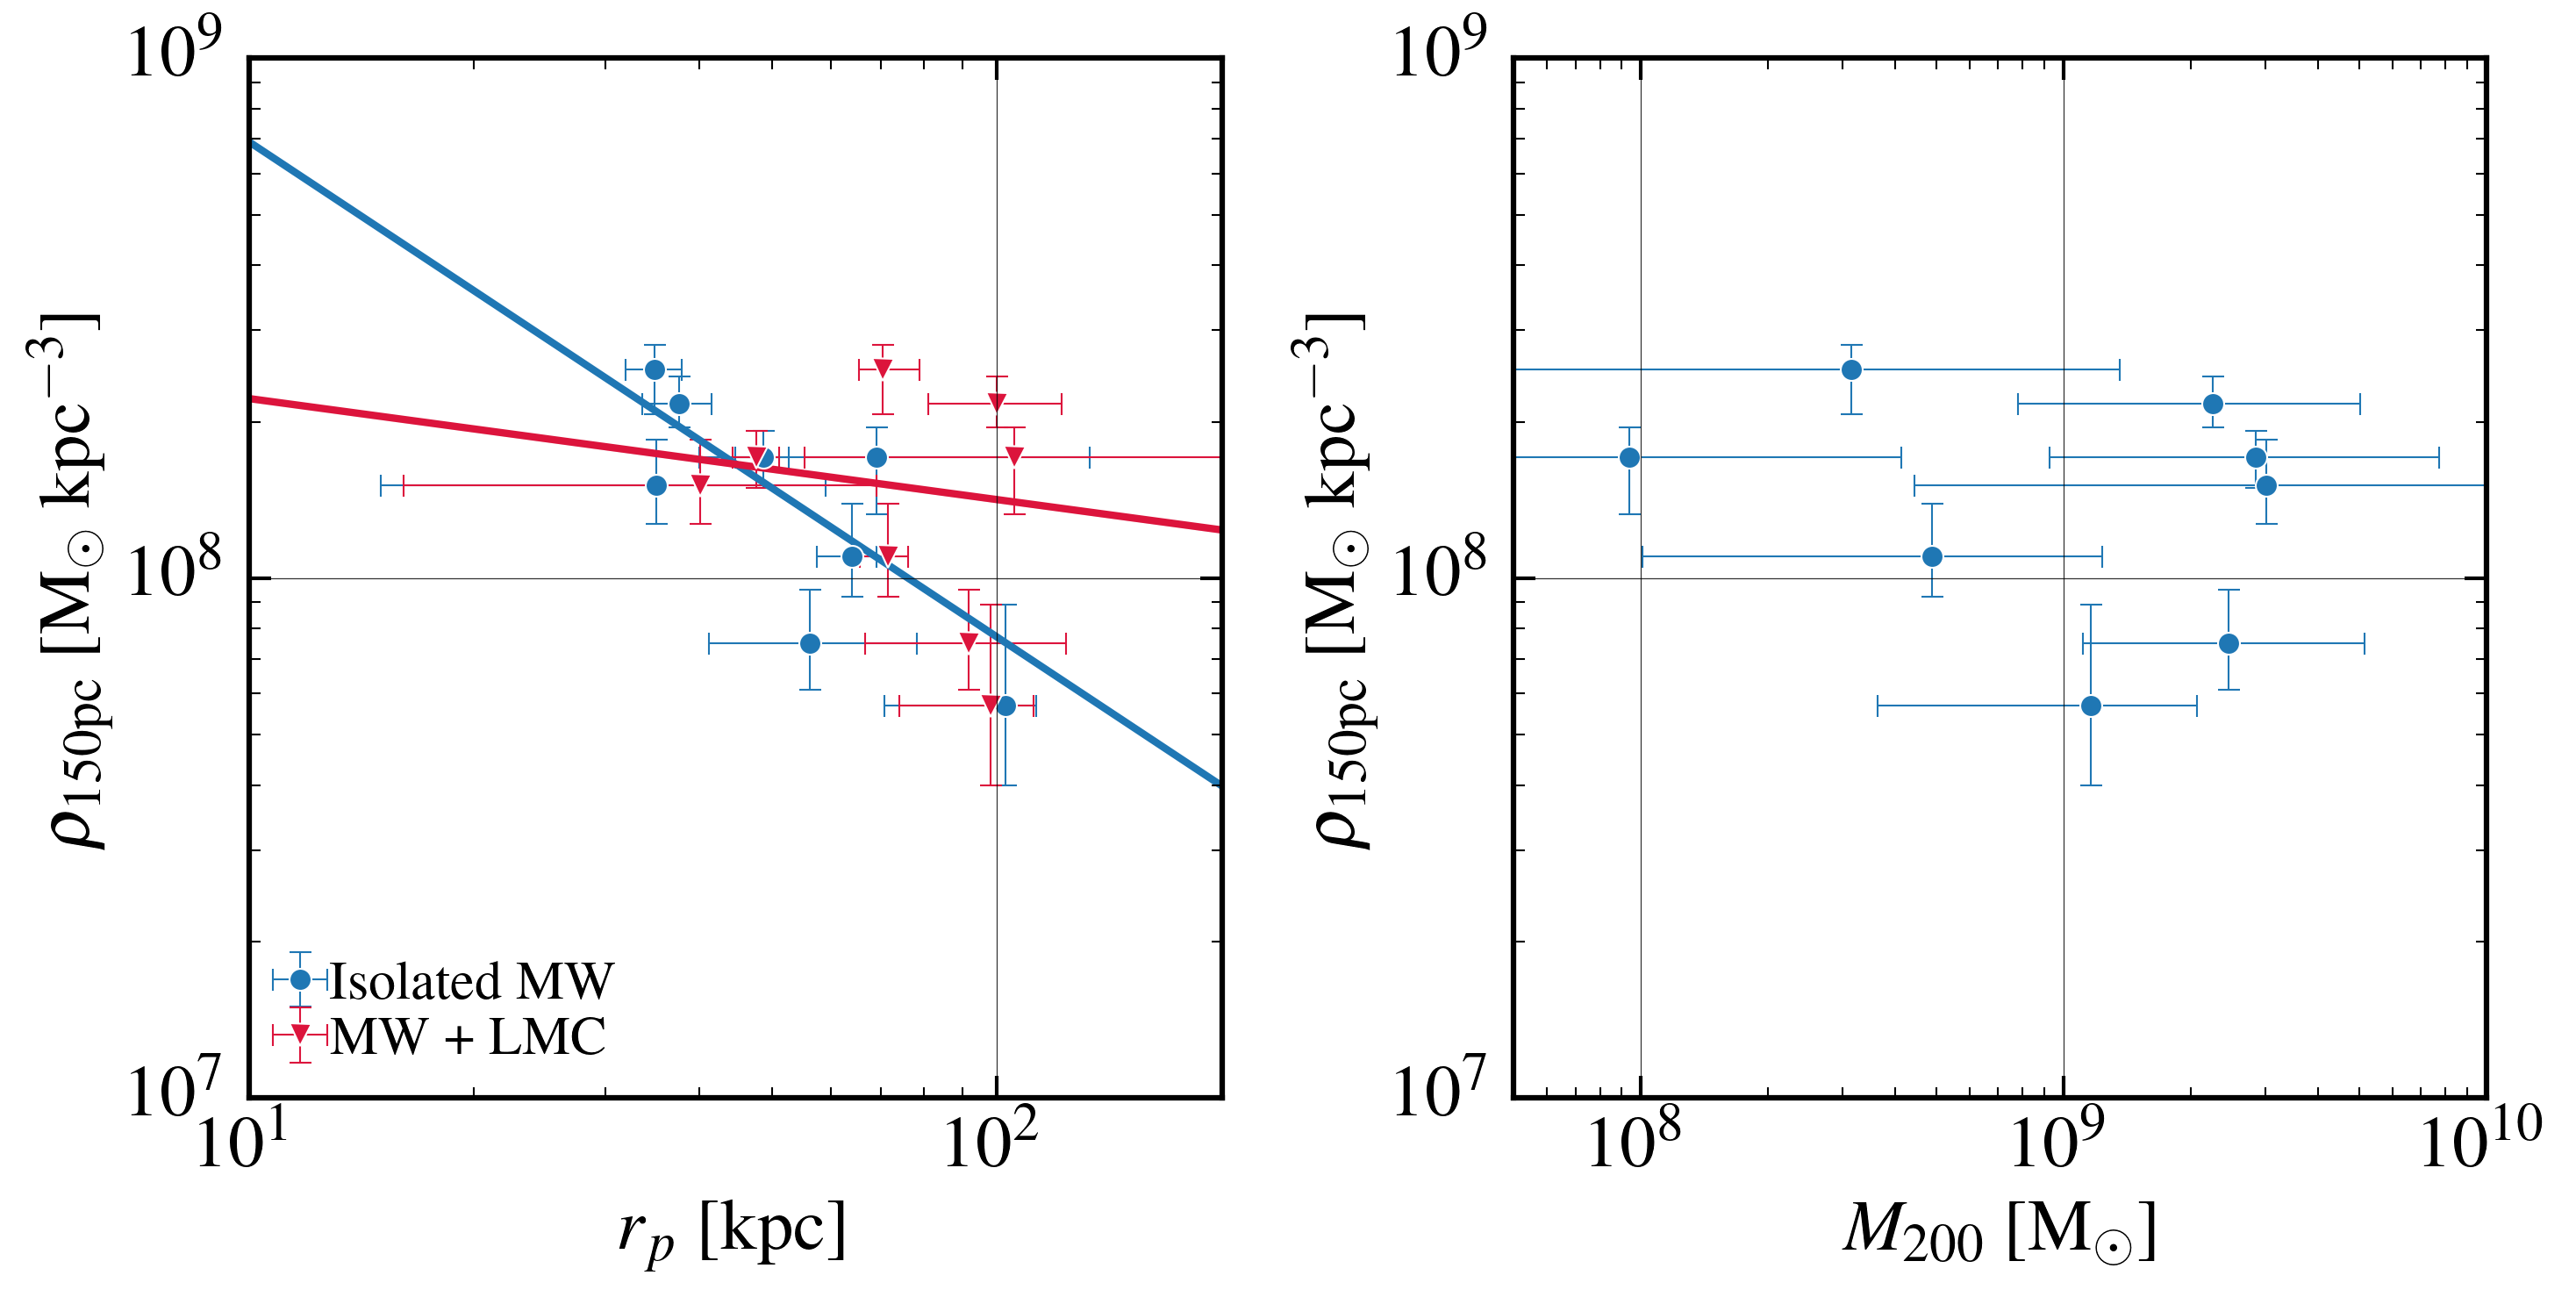

In [15]:
def plot_Gaia_data(axs):
    # Data points
    axs[0].errorbar(r_p_Isolated[0,:], rho_150pc_K19[0,:], xerr=r_p_Isolated[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='o', markersize=6, markeredgecolor="white", ls='none', lw=0.5, c='tab:blue',label='Isolated MW')
    axs[0].errorbar(r_p_LMC[0,:], rho_150pc_K19[0,:], xerr=r_p_LMC[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='v', markersize=6, markeredgecolor="white", ls='none', lw=0.5, c='crimson',label='MW + LMC')

    # Fit
    xrange = np.arange(np.log10(10), np.log10(500), 0.2)
    num_range = len(xrange)
    for samples, color in zip([samples_isolated, samples_LMC], ["tab:blue", "crimson"]):
        q = np.median(samples[:, 0])
        m = np.median(samples[:, 1])
        yrange = np.ones((2,num_range))
        for i in range(num_range):
            yrange[0, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 16)
            yrange[1, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 84)
        axs[0].fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color=color, alpha=0.1)
        axs[0].plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '-', lw=2, color=color)


    axs[0].grid(linestyle='-', linewidth=0.3)
    axs[0].legend(loc=[0.01, 0.01], labelspacing=0.1,
            handlelength=0.7, handletextpad=0.2,
            frameon=False, fontsize=15, ncol=1, numpoints=1)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    axs[0].set_xlabel("$r_{p}$ [kpc]")

    ####
    axs[1].grid(linestyle='-', linewidth=0.3)
    axs[1].errorbar(M200_K19[0,:-1], rho_150pc_K19[0,:], yerr=rho_150pc_K19[1:,:], xerr=M200_K19[1:,:-1],
                marker='o', markersize=6, markeredgecolor="white", ls='none', lw=0.5, c='tab:blue')

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    axs[1].set_xlabel("$M_{200}$ [M$_{\odot}$]")
    
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
plot_Gaia_data(axs)
axs[0].axis([10, 200, 1e7, 1e9])
axs[1].axis([5e7, 1e10, 1e7, 1e9])


In [ ]:
# Comment: CC. What's below has been moved to notebooks 13, 14 and 15 for easier analysis 

In [ ]:
def plot_obs(axs):

    # Data points
    axs.errorbar(r_p_Isolated[0,:], rho_150pc_K19[0,:], xerr=r_p_Isolated[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='o', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='tab:blue',label='Isolated MW')
    axs.errorbar(r_p_LMC[0,:], rho_150pc_K19[0,:], xerr=r_p_LMC[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='v', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='crimson',label='MW + LMC')

    # Fit
    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    for samples, color in zip([samples_isolated, samples_LMC], ["tab:blue", "crimson"]):
        q = np.median(samples[:, 0])
        m = np.median(samples[:, 1])
        yrange = np.ones((2,num_range))
        for i in range(num_range):
            yrange[0, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 16)
            yrange[1, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 84)
        axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color=color, alpha=0.1)
        axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '--', lw=1, color=color)

    axs.legend(loc=[0.01, 0.01], labelspacing=0.1, handlelength=0.7, handletextpad=0.2, frameon=False, fontsize=15, ncol=1, numpoints=1)
    axs.set_yscale('log')
    axs.set_xscale('log')
    # axs.set_ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    axs.set_xlabel("$r_{p}$ [kpc]")
    axs.axis([10, 1e3, 2e6, 2e9])


## Simulated data (NFW fit)

In [ ]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
#    "SigmaConstant10": "SigmaConstant10", # I will not include this sim. since its cross section is already ruled out by galaxy clusters
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

In [ ]:
for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    # Add simulations points
    for idx in file.keys():
        if file[f'{idx}'].attrs.get('subhalo_of') is not None:    
            data_subhalo = file[f'{idx}']
            nfw_fit = data_subhalo['halo_data']['nfw_fit']
            r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
            rho_s = 10**log10_rho_s
            sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
            rho = NFW_profile(r_range, rho_s, r_s)
            mass_within_r = mass(rho, r_range)
            rho_within_r = rho_mean(mass_within_r, r_range)
            R200 = calculate_R200(rho_within_r, r_range)
            M200 = calculate_M200(R200)

            ## Dealing with error propagation..
            error_rho = (sigma_rho_s / rho_s)**2
            error_rho += ( (sigma_r_s / r_s) * ((3. + r_s / r_range) / (1. + r_s / r_range)) )**2
            error_rho *= rho**2
            error_rho = np.sqrt(error_rho)
            
            low_error_rho = rho - error_rho
            mass_within_r = mass(low_error_rho, r_range)
            rho_within_r = rho_mean(mass_within_r, r_range)
            sigma_R200 = calculate_R200(rho_within_r, r_range)
            sigma_M200 = M200 - calculate_M200(R200)
            
            r_p = data_subhalo['tree_data']['pericenter'][1]
            rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
            
            axs[0].scatter(r_p, rho_150, c=np.log10(M200), cmap='magma', marker='.', lw=0, vmin=np.log10(5e7), vmax=np.log10(4e10), alpha=0.5, s=30)
            axs[1].scatter(M200, rho_150, c=np.log10(M200), cmap='magma', marker='.', lw=0, vmin=np.log10(5e7), vmax=np.log10(4e10), alpha=0.5, s=30)

    axs[1].scatter([], [], c='k', marker='.', alpha=0.5, s=30, lw=0, label=id_name)
    axs[1].legend(loc=[0.01, 0.01], labelspacing=0.1,
                handlelength=0.7, handletextpad=0.2,
                frameon=False, fontsize=15, ncol=1)
    
    axs[0].axis([10, 1e3, 1e7, 1e9])
    axs[1].axis([5e7, 4e10, 1e7, 1e9])

    # Add Gaia data
    plot_Gaia_data(axs)

    ####
    plt.tight_layout()
    plt.show()
    
    file.close()

In [ ]:
#################
# Plot parameters
params = {
    "font.size": 11,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (12, 7),
    "figure.subplot.left": 0.06,
    "figure.subplot.right": 0.98,
    "figure.subplot.bottom": 0.17,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.02,
    "figure.subplot.hspace": 0.02,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)

plt.figure()

mycmap = matplotlib.cm.RdYlBu
cmap = matplotlib.colors.ListedColormap(['olivedrab', mycmap(0.9), 'peru', mycmap(0.1), 'darkorchid', 'midnightblue'])


for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = plt.subplot(2, 3, i+1)

    x = []
    y = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get('subhalo_of') is not None:    
            data_subhalo = file[f'{idx}']
            nfw_fit = data_subhalo['halo_data']['nfw_fit']
            r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
            rho_s = 10**log10_rho_s
            sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
            rho = NFW_profile(r_range, rho_s, r_s)
            mass_within_r = mass(rho, r_range)
            rho_within_r = rho_mean(mass_within_r, r_range)
            R200 = calculate_R200(rho_within_r, r_range)
            M200 = calculate_M200(R200)
            r_p = data_subhalo['tree_data']['pericenter'][1]
            rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
            
            axs.scatter(r_p, rho_150, c=np.log10(M200), cmap=cmap, marker='.', 
                        lw=0, vmin=np.log10(5e7), vmax=np.log10(4e10), alpha=1, s=50)

            # Let's append for this sim:
            x = np.append(x, r_p)
            y = np.append(y, rho_150)

    # Some values for rho_150 do not look good, let's clean..
    clean = np.where((y>=1e6) & (y<=1e10))[0]
    y = y[clean]
    x = x[clean]

    samples_Simulation = run_best_fit_for_sim_with_mcmc(x, y)

    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    q = np.median(samples_Simulation[:, 0])
    m = np.median(samples_Simulation[:, 1])
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], samples_Simulation[:, 0], samples_Simulation[:, 1]), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], samples_Simulation[:, 0], samples_Simulation[:, 1]), 84)

    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.3)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '--', lw=1, color='black')

    props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
    axs.text(0.05, 0.15, id_name, transform=axs.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)
    
    plt.axis([10, 1e3, 2e6, 2e9])
    plt.xscale('log')
    plt.yscale('log')

    xticks = np.array([10, 100, 500])
    labels = ["10","100","500"]
    plt.xticks(xticks, labels)
    
    if i >= 3:
        plt.xlabel(r"$r_{p}$ [kpc]")
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i == 0) or (i==3):
        plt.ylabel(r"$\rho_{\mathrm{150pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    else:
        axs.get_yaxis().set_ticklabels([])


    ####
    file.close()

####
axs = plt.subplot(2, 3, 6)
plot_obs(axs)
xticks = np.array([10, 100, 500])
labels = ["10","100","500"]
plt.xticks(xticks, labels)
axs.get_yaxis().set_ticklabels([])

plt.savefig('Density_pericenter.png',dpi=300)
plt.show()


In [ ]:
#################
# Plot parameters
params = {
    "font.size": 11,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (12, 7),
    "figure.subplot.left": 0.06,
    "figure.subplot.right": 0.98,
    "figure.subplot.bottom": 0.17,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.02,
    "figure.subplot.hspace": 0.02,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
plt.figure()

mycmap = matplotlib.cm.RdYlBu
cmap = matplotlib.colors.ListedColormap(['olivedrab', mycmap(0.9), 'peru', mycmap(0.1), 'darkorchid', 'midnightblue'])


for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = plt.subplot(2, 3, i+1)

    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                rho = NFW_profile(r_range, rho_s, r_s)
                mass_within_r = mass(rho, r_range)
                rho_within_r = rho_mean(mass_within_r, r_range)
                R200 = calculate_R200(rho_within_r, r_range)
                _M200 = calculate_M200(R200)
                M200 = np.append(M200, _M200)

            axs.scatter(rp, rho150, c=np.log10(M200), cmap=cmap, marker='.', 
                        lw=0, vmin=np.log10(5e7), vmax=np.log10(4e10), alpha=1, s=50)

            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)
    

    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 84)

    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.15)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=4, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=1.5, color='black')

    props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
    axs.text(0.05, 0.15, id_name, transform=axs.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)
        
    plt.axis([10, 1e3, 2e6, 2e9])
    plt.xscale('log')
    plt.yscale('log')

    xticks = np.array([10, 100, 500])
    labels = ["10","100","500"]
    plt.xticks(xticks, labels)
    
    if i >= 3:
        plt.xlabel(r"$r_{p}$ [kpc]")
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i == 0) or (i==3):
        plt.ylabel(r"$\rho_{\mathrm{150pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()

####
axs = plt.subplot(2, 3, 6)
plot_obs(axs)
xticks = np.array([10, 100, 500])
labels = ["10","100","500"]
plt.xticks(xticks, labels)
axs.get_yaxis().set_ticklabels([])

####
plt.savefig('Density_pericenter_v2.png',dpi=300)
plt.show()



In [ ]:
plt.style.use("pltstyle.mplstyle")
params = {
    "font.size": 11,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (5, 3),
    "figure.subplot.left": 0.1,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
plt.figure()
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)
    

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m) - np.percentile(m,16)
    merr[1,0]= np.percentile(m,84) - np.median(m)
    plt.errorbar(np.array([i]), np.array(np.median(m)), yerr=merr, marker='o', markersize=6, 
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    ####
    file.close()

plt.errorbar(np.array([i+1]), np.array(-0.6), yerr=np.ones((2, 1))*0.4, marker='*', markersize=12, 
                 markeredgecolor="white", ls='none', lw=1.5, label='Isolated MW', color='black')
plt.errorbar(np.array([i+2]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='>', markersize=10, 
                 markeredgecolor="white", ls='none', lw=1.5, label='MW+LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.1, handlelength=0.3, handletextpad=0.1, 
           frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)
plt.xticks([])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho_{150\mathrm{pc}}}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')
plt.axis([-0.5, 7, -1.2, 1.0])

####
plt.savefig('Density_pericenter_slope.png',dpi=300)
plt.show()


In [ ]:
plt.style.use("pltstyle.mplstyle")
params = {
    "font.size": 11,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (4.5, 7),
    "figure.subplot.left": 0.1,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.05,
    "figure.subplot.hspace": 0.05,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
plt.figure()

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = plt.subplot(2, 1, i+1)
    axs.fill_between(np.array([1e7, 1e9]), np.array([2e6, 2e6]), np.array([2e9, 2e9]), color='grey', alpha=0.15)

    # Add simulations points
    rp, rho150, M200 = [], [], []
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                rho = NFW_profile(r_range, rho_s, r_s)
                mass_within_r = mass(rho, r_range)
                rho_within_r = rho_mean(mass_within_r, r_range)
                R200 = calculate_R200(rho_within_r, r_range)
                _M200 = calculate_M200(R200)
                M200 = np.append(M200, _M200)

    axs.plot(M200, rho150, 'o', ms=5, color='grey', markeredgecolor='none', alpha=0.5)
    m_bins = np.arange(9, 11.2, 0.2)
    m_bins = 10**m_bins
    select = np.where(M200>=1e9)[0]
    plot_median_relation(axs, m_bins, M200[select], rho150[select], color='black')

    axs.errorbar(M200_K19[0,:-1], rho_150pc_K19[0,:], yerr=rho_150pc_K19[1:,:], xerr=M200_K19[1:,:-1],
                 marker='o', markersize=5.5, markeredgecolor="white", ls='none', lw=1.5, c='darkblue',label='K19', zorder=1000)
    
    props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
    axs.text(0.05, 0.15, id_name, transform=axs.transAxes, fontsize=16, verticalalignment='top', bbox=props, zorder=1000)
        
    plt.axis([1e7, 1e11, 2e6, 2e9])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r"$\rho_{\mathrm{150pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    
    if i == 0:
        plt.xticks([])
    else:
        plt.xlabel(r"$M_{200}$ [M$_{\odot}$]")

    ####
    file.close()

plt.savefig('Density_M200.png',dpi=300)
plt.show()